In [106]:
import pandas as pd
import os
import xml.etree.ElementTree as ET, urllib.request, gzip, io
import numpy as np
import matplotlib.pyplot as plt

In [380]:
nasa_df = pd.read_csv('NASA_cumulative_2023.03.12_03.51.03.csv', skiprows=144)
nasa_df.set_index('rowid', inplace=True)

In [382]:
nasa_df['koi_disposition'].value_counts()

FALSE POSITIVE    4839
CONFIRMED         2671
CANDIDATE         2054
Name: koi_disposition, dtype: int64

In [108]:
nasa_df['ExoplanetConfirmed'] = nasa_df['koi_disposition'].apply(lambda x: 1 if x == 'CONFIRMED' else 0)

<h4><b> Renaming </b></h4>

In [109]:
names = pd.read_csv('NASA_cumulative_2023.03.12_03.51.03.csv',skiprows=3, nrows=140, names=['full'])

names[['A', 'B']] = names['full'].str.split(':', 1, expand=True)
names[['AA', 'AAA']] = names['A'].str.split('COLUMN', 1, expand=True)

names.drop(columns=['full', 'A', 'AA'], inplace=True)
names.rename(columns={'B':'fullname',
                      'AAA':'currentname'}, inplace=True)
names = names.replace(' ', '', regex=True)

In [110]:
renaming = {}
for i, r in names.iterrows():
  renaming[r.currentname] = r.fullname

#rename columns with their full name
nasa_df = nasa_df.rename(columns=renaming)

In [111]:
todrop = ['KepID', 'KOIName', 'KeplerName', 'ExoplanetArchiveDisposition', 'VettingStatus', 
        'DateofLastParameterUpdate', 'DispositionUsingKeplerData', 'DispositionScore',
        'Comment', 'NotTransit-LikeFalsePositiveFlag', 
        'DispositionProvenance']

nasa_df.drop(columns=todrop, inplace=True)

### Remove error columns

Some columns are the errors margins of the calculations in other columns. We will remove these error columns

In [112]:
err_colummns = []

# go over cols and get every col with 'Unc.' in it
for c in nasa_df.columns:
  if 'Unc.' in c:
    err_colummns.append(c)


# finalize changes, but hold on to the data with error in case we need it later
nasa_df = nasa_df.drop(err_colummns, axis = 1)

print(f"\nDataset had {nasa_df.shape[1]} columns.\nIt now has {nasa_df.shape[1]} columns.")


Dataset had 72 columns.
It now has 72 columns.


In [379]:
nasa_df['ExoplanetConfirmed']

rowid
1       1
2       1
3       0
4       0
5       1
       ..
9560    0
9561    0
9562    0
9563    0
9564    0
Name: ExoplanetConfirmed, Length: 9466, dtype: int64

# Handle Missing Data

<AxesSubplot:>

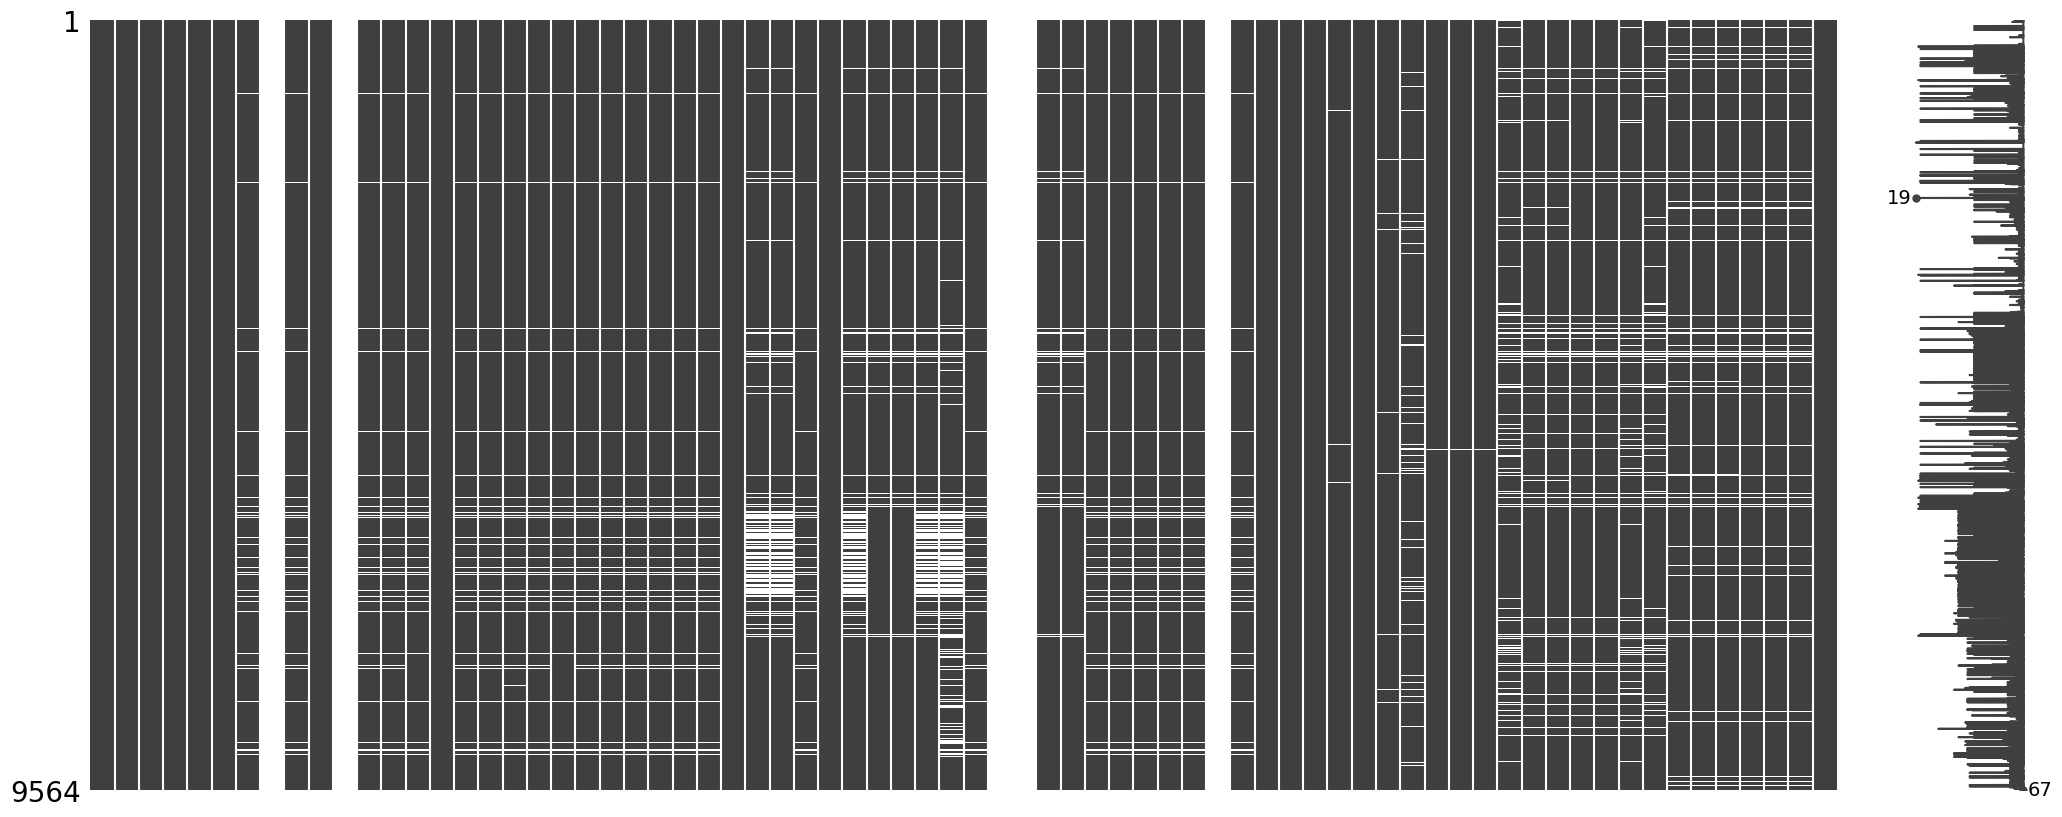

In [113]:
import missingno as msno
msno.matrix(pd.concat([nasa_df]))

### Drop all columns that have more than 50% missing

Here we dropped all columns that have more than 50% of their data missing.

In [114]:
nasa_df = nasa_df.loc[:, nasa_df.isnull().mean() < .5]

### Drop all rows that have more than 50% missing

<AxesSubplot:>

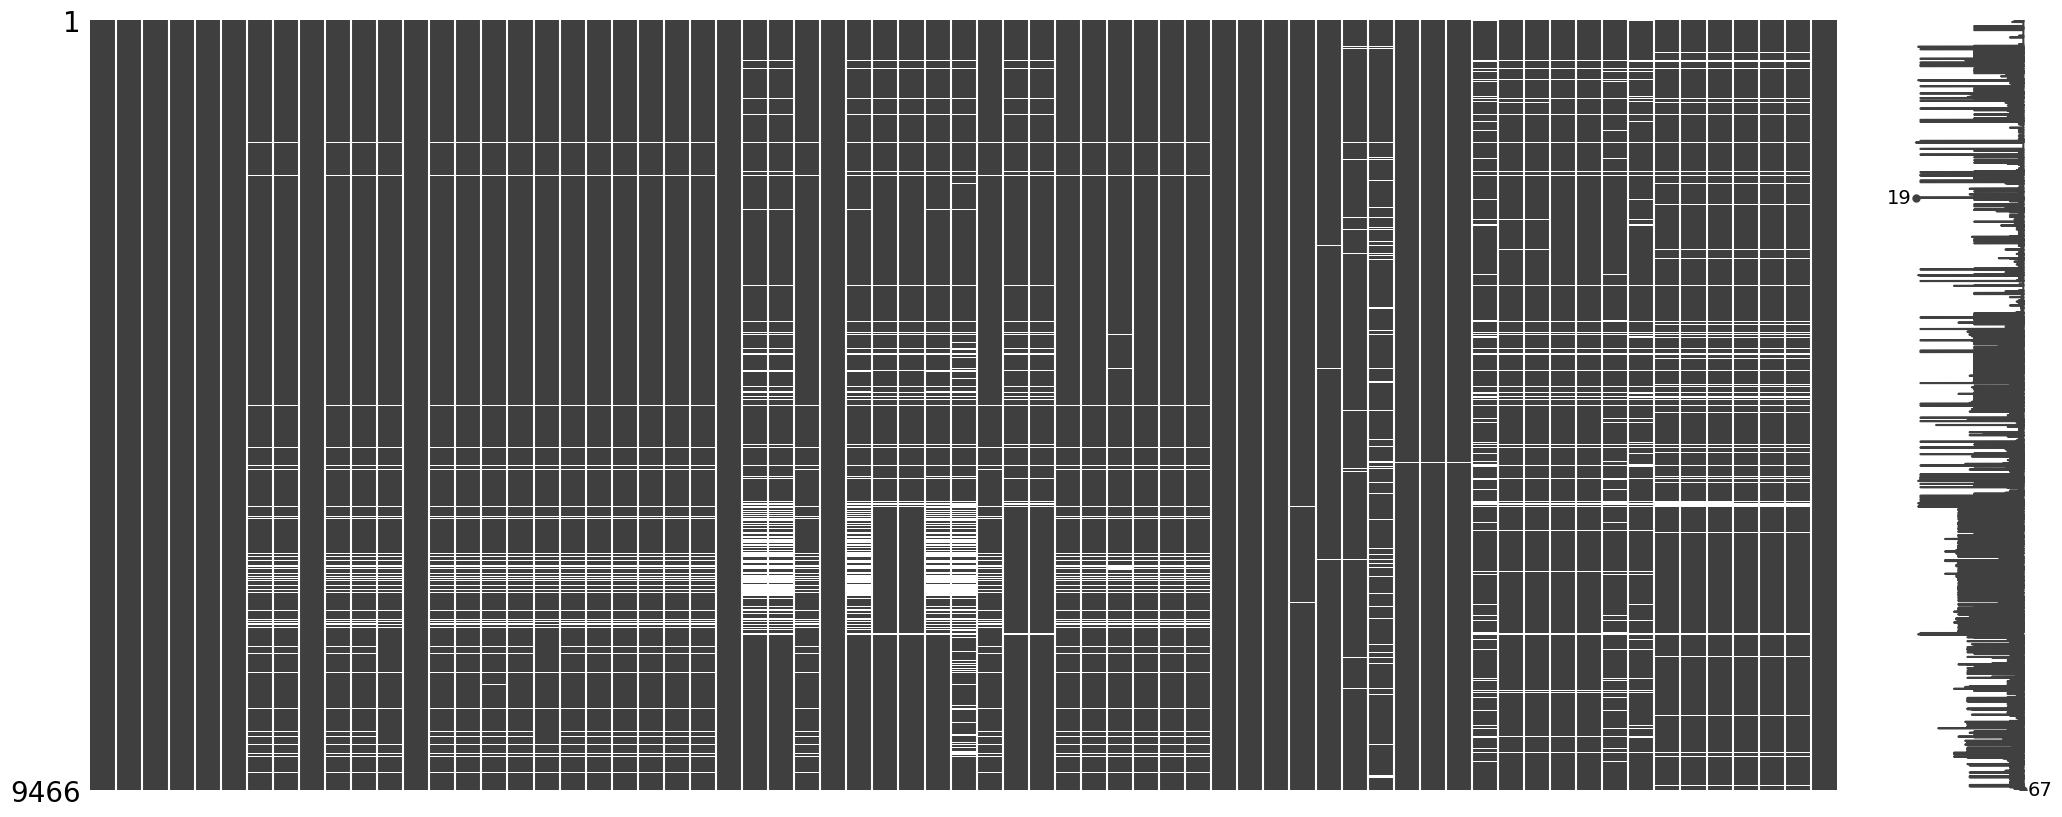

In [115]:
per_row = []
for index in range(len(nasa_df.index)) :
  per_row.append([index, nasa_df.iloc[index].isna().mean()])

row_missing = pd.DataFrame(per_row, columns=['index', 'missing']).sort_values(by='missing', ascending=False)
rows_to_delete = list(row_missing.loc[row_missing['missing'] > 0.5].index)
nasa_df = nasa_df.drop(rows_to_delete,axis='index')
msno.matrix(pd.concat([nasa_df]))

<h2><b> Encoding categorical data </b></h2>

In [116]:
df_categorical = nasa_df.select_dtypes(object)

In [117]:
df_categorical.drop(['LimbDarkeningModel', 'TransitModel', 'LinktoDVReport', 'LinktoDVSummary', 'Quarters'], axis=1, inplace=True)

In [118]:
#categorical data
categorical_cols = ['PlanetaryFitType', 'ParametersProvenance', 'TCEDelivery', 'StellarParameterProvenance'] 

#import pandas as pd
df_categorical = pd.get_dummies(df_categorical, columns = categorical_cols)

In [119]:
nasa_df.drop(categorical_cols + ['LimbDarkeningModel', 'TransitModel', 'LinktoDVReport', 'LinktoDVSummary', 'Quarters', 'Eccentricity'], axis=1, inplace=True)

In [120]:
nasa_df = pd.concat([nasa_df, df_categorical], axis=1)

<h2><b> Imputation </b></h2>

In [121]:
from sklearn.impute import KNNImputer
df_imputer_knn = nasa_df.copy(deep=True)

In [122]:
# Impute the feature
knnimputer = KNNImputer(n_neighbors=3)
df_imputer_knn.iloc[:,:] = knnimputer.fit_transform(df_imputer_knn)

<AxesSubplot:>

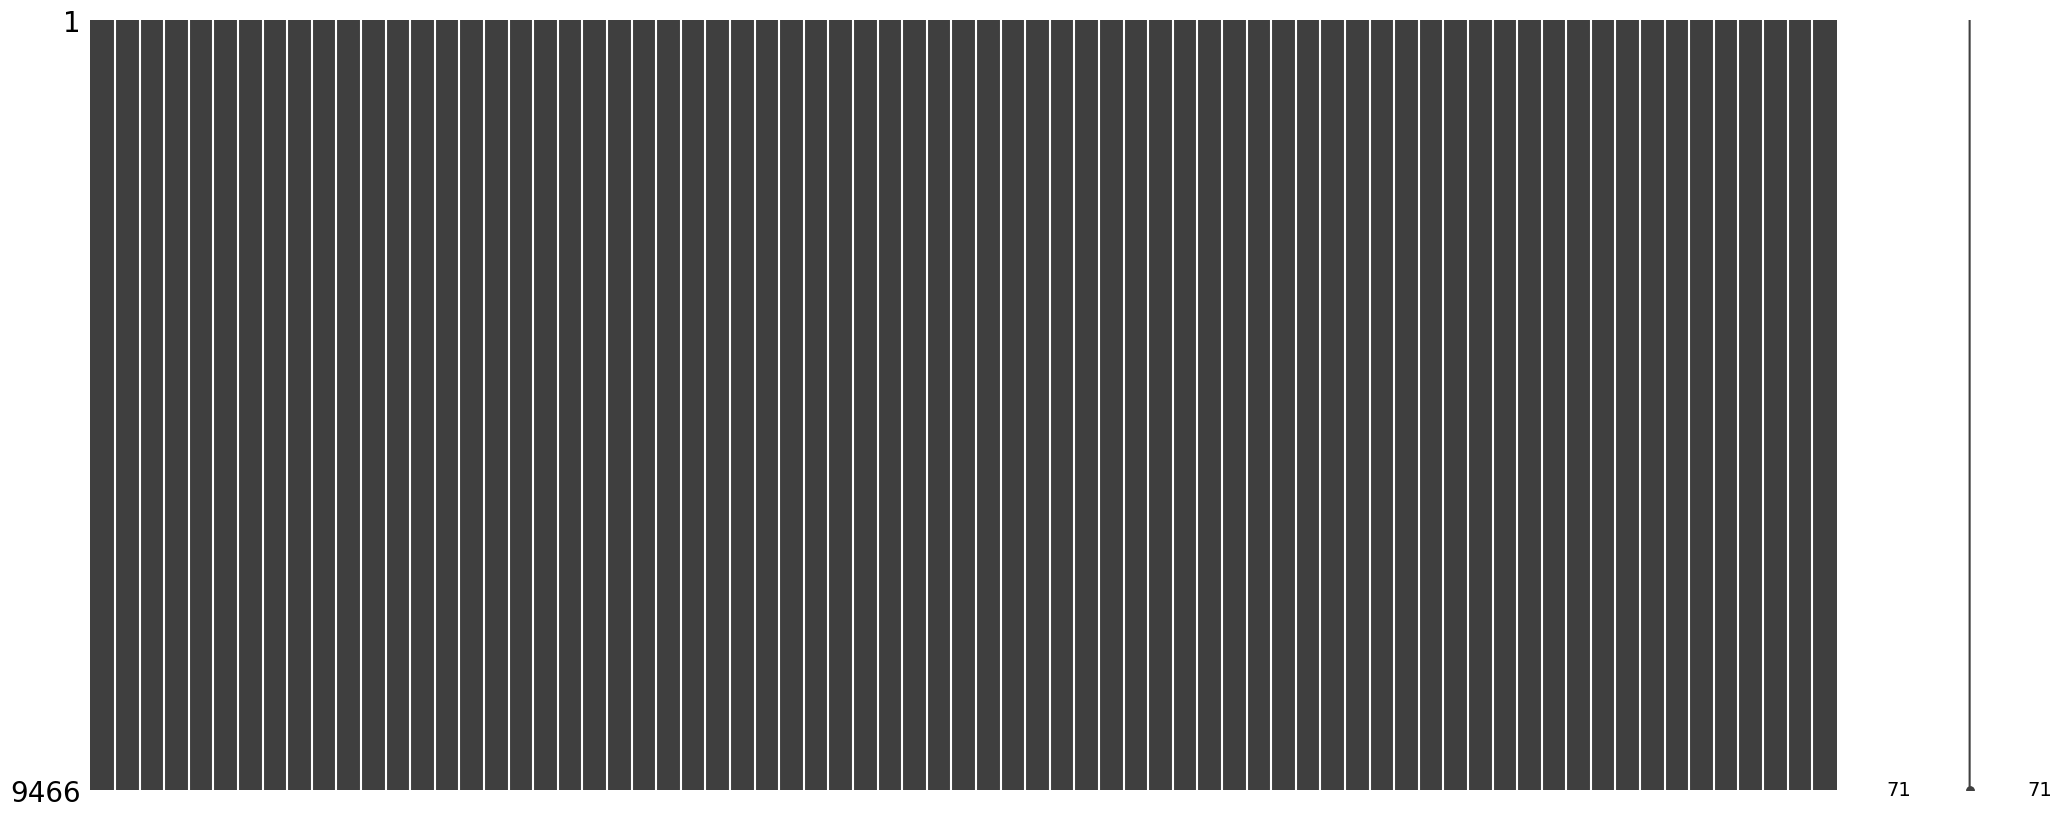

In [123]:
msno.matrix(pd.concat([df_imputer_knn]))

### Normalization

In [124]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [125]:
X = df_imputer_knn.drop('ExoplanetConfirmed', axis=1)
y = df_imputer_knn['ExoplanetConfirmed']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [126]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

<h2><b> Feature Importance </b></h2>

In [127]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [128]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

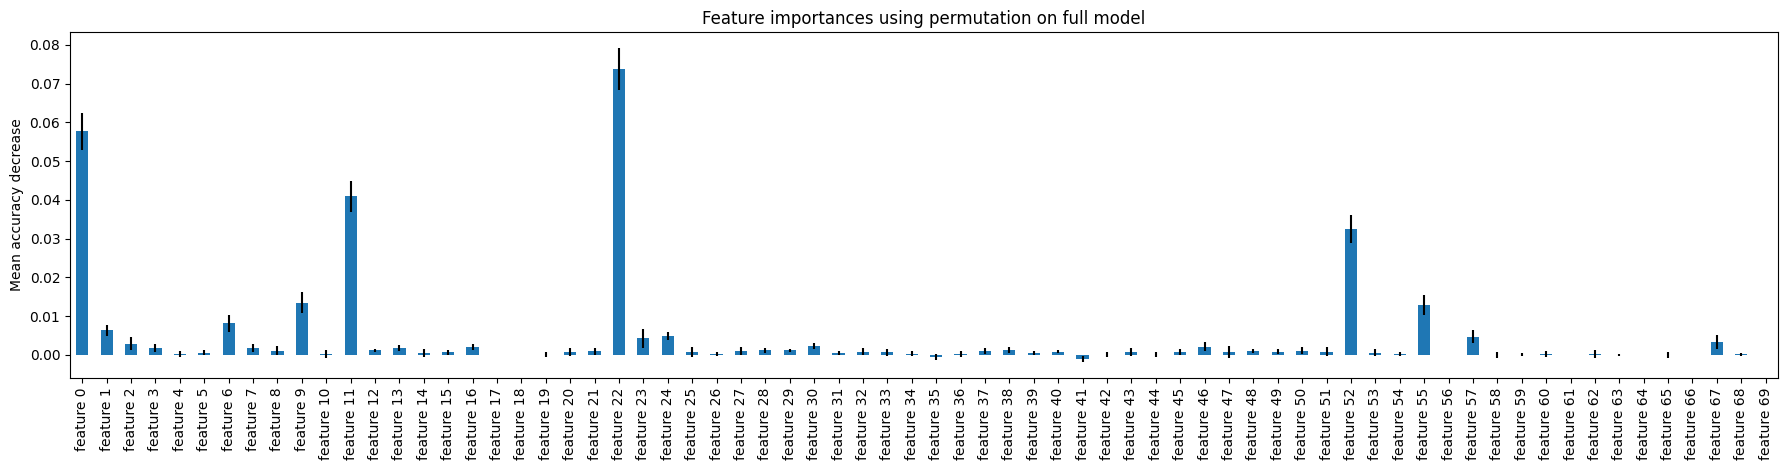

In [129]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
fig.set_figwidth(20)
plt.show()

In [181]:
result.importances_mean

array([ 5.76256865e-02,  6.29488804e-03,  2.91508238e-03,  1.81664554e-03,
        2.95732995e-04,  5.49218420e-04,  8.15378116e-03,  1.77439797e-03,
        1.09843684e-03,  1.34769751e-02,  2.11237854e-04,  4.08534009e-02,
        1.14068441e-03,  1.68990283e-03,  5.06970849e-04,  6.33713561e-04,
        1.94338826e-03,  0.00000000e+00,  0.00000000e+00,  8.44951415e-05,
        7.18208703e-04,  9.29446557e-04,  7.37220110e-02,  4.22475708e-03,
        4.85847064e-03,  8.02703845e-04,  1.26742712e-04,  9.71694128e-04,
        1.14068441e-03,  1.14068441e-03,  2.32361639e-03,  5.06970849e-04,
        8.44951415e-04,  6.33713561e-04,  2.95732995e-04, -5.49218420e-04,
        1.26742712e-04,  9.29446557e-04,  1.18293198e-03,  4.64723278e-04,
        8.02703845e-04, -1.05618927e-03,  2.22044605e-17,  6.75961132e-04,
        8.44951415e-05,  8.02703845e-04,  2.11237854e-03,  6.33713561e-04,
        9.71694128e-04,  8.44951415e-04,  1.09843684e-03,  8.02703845e-04,
        3.24461343e-02,  

<h2><b>PCA Outlier Detection </b></h2>

In [142]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [148]:
features = df_imputer_knn.columns[:]

In [149]:
df_pca = df_imputer_knn.loc[:, features].values
df_pca = StandardScaler().fit_transform(df_pca)

In [150]:
pca = PCA(n_components=2)  # Choose the number of principal components
principal_components = pca.fit_transform(df_pca)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [151]:
euclidean_distance = pd.Series(
    [sum(np.square(row)) for row in principal_components],
    name='EuclideanDistance'
)

In [202]:
df_temp_nasa = pd.concat([df_imputer_knn, principal_df, euclidean_distance], axis=1)

In [204]:
df_temp_nasa.dropna(inplace=True)

In [205]:
outliers = df_temp_nasa[df_temp_nasa['EuclideanDistance'] > 80]

In [206]:
outliers

,StellarEclipseFalsePositiveFlag,CentroidOffsetFalsePositiveFlag,EphemerisMatchIndicatesContaminationFalsePositiveFlag,OrbitalPeriod[days],TransitEpoch[BKJD],TransitEpoch[BJD],ImpactParameter,TransitDuration[hrs],TransitDepth[ppm],Planet-StarRadiusRatio,...,TCEDelivery_q1_q16_tce,TCEDelivery_q1_q17_dr24_tce,TCEDelivery_q1_q17_dr25_tce,StellarParameterProvenance_Solar,StellarParameterProvenance_q1_q17_dr25_stellar,StellarParameterProvenance_stellar_q1_q16,StellarParameterProvenance_stellar_q1_q17,PC1,PC2,EuclideanDistance
326,1.0,0.0,0.0,17.512015,174.282592,2455007.283,0.994,1.8248,4511.7,0.110483,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,9.993112,-8.231363,167.617637
327,0.0,0.0,0.0,3.988602,171.018520,2455004.019,0.060,1.7376,673.5,0.023067,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,11.765689,-9.284306,224.629767
341,0.0,1.0,1.0,0.933749,134.318310,2454967.318,0.736,4.2560,186.2,0.013481,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,19.939171,28.347599,1201.156882
345,0.0,0.0,0.0,17.157236,133.689510,2454966.690,0.238,11.2840,110.4,0.009558,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,8.069472,-5.859003,99.444301
347,0.0,0.0,0.0,13.118962,261.539434,2455094.539,0.042,4.3045,372.2,0.017826,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,7.772352,-6.576395,103.658424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9135,0.0,1.0,1.0,0.566799,131.814220,2454964.814,0.010,2.7770,59.9,0.007001,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,7.526615,-9.227807,141.802366
9140,0.0,1.0,1.0,0.566808,131.788800,2454964.789,0.155,2.1600,31.5,0.004986,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,8.012850,-4.480159,84.277587
9170,0.0,0.0,0.0,328.048500,301.512600,2455134.513,0.329,13.7500,398.0,0.018484,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,8.019243,-4.112471,81.220678
9302,0.0,0.0,0.0,7.752934,137.487700,2454970.488,0.449,5.0720,72.1,0.007937,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,8.804933,-3.871003,92.511506


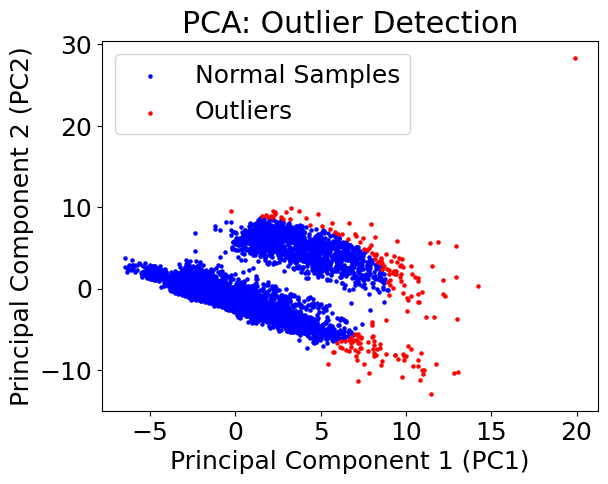

In [166]:
import matplotlib.pyplot as plt

# Assuming you already have the 'outliers' DataFrame
normal_samples = df_temp_nasa.drop(outliers.index)  # Exclude outliers from normal samples

# Plotting the normal samples
plt.scatter(normal_samples['PC1'], normal_samples['PC2'], color='blue', label='Normal Samples', s=5)

# Plotting the outliers
plt.scatter(outliers['PC1'], outliers['PC2'], color='red', label='Outliers', s=5)

plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('PCA: Outlier Detection')
plt.legend()
plt.show()

### Remove all outliers 

In [211]:
df_work = df_temp_nasa[df_temp_nasa['EuclideanDistance'] < 80].drop(['PC1', 'PC2', 'EuclideanDistance'], axis=1)

In [212]:
df_work

,StellarEclipseFalsePositiveFlag,CentroidOffsetFalsePositiveFlag,EphemerisMatchIndicatesContaminationFalsePositiveFlag,OrbitalPeriod[days],TransitEpoch[BKJD],TransitEpoch[BJD],ImpactParameter,TransitDuration[hrs],TransitDepth[ppm],Planet-StarRadiusRatio,...,ParametersProvenance_q1_q16_koi,ParametersProvenance_q1_q17_dr24_koi,ParametersProvenance_q1_q17_dr25_koi,TCEDelivery_q1_q16_tce,TCEDelivery_q1_q17_dr24_tce,TCEDelivery_q1_q17_dr25_tce,StellarParameterProvenance_Solar,StellarParameterProvenance_q1_q17_dr25_stellar,StellarParameterProvenance_stellar_q1_q16,StellarParameterProvenance_stellar_q1_q17
1,0.0,0.0,0.0,9.488036,170.538750,2455003.539,0.146,2.95750,615.8,0.022344,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,54.418383,162.513840,2454995.514,0.586,4.50700,874.8,0.027954,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,19.899140,175.850252,2455008.850,0.969,1.78220,10829.0,0.154046,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.736952,170.307565,2455003.308,1.276,2.40641,8079.2,0.387394,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,2.525592,171.595550,2455004.596,0.701,1.65450,603.3,0.024064,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9461,0.0,0.0,0.0,386.354440,359.091400,2455192.091,0.705,9.59400,129.6,0.011133,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
9462,0.0,0.0,0.0,371.214540,497.526600,2455330.527,1.254,19.40000,1780.0,0.303955,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
9463,0.0,0.0,0.0,365.543500,132.690400,2454965.690,0.518,14.78000,753.1,0.025896,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
9464,0.0,1.0,0.0,7.029323,134.664340,2454967.664,0.098,2.85300,81.6,0.008228,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [218]:
import seaborn as sns

In [238]:
corr_matrix = df_work.corr(method="pearson")

In [226]:
corr_matrix

,StellarEclipseFalsePositiveFlag,CentroidOffsetFalsePositiveFlag,EphemerisMatchIndicatesContaminationFalsePositiveFlag,OrbitalPeriod[days],TransitEpoch[BKJD],TransitEpoch[BJD],ImpactParameter,TransitDuration[hrs],TransitDepth[ppm],Planet-StarRadiusRatio,...,ParametersProvenance_q1_q16_koi,ParametersProvenance_q1_q17_dr24_koi,ParametersProvenance_q1_q17_dr25_koi,TCEDelivery_q1_q16_tce,TCEDelivery_q1_q17_dr24_tce,TCEDelivery_q1_q17_dr25_tce,StellarParameterProvenance_Solar,StellarParameterProvenance_q1_q17_dr25_stellar,StellarParameterProvenance_stellar_q1_q16,StellarParameterProvenance_stellar_q1_q17
StellarEclipseFalsePositiveFlag,1.000000,0.150559,0.100236,0.019633,0.110994,0.110994,0.041197,0.029956,0.423428,0.033394,...,0.181402,0.053046,0.188765,0.155675,0.053046,0.188765,0.075479,0.159030,0.158624,0.044887
CentroidOffsetFalsePositiveFlag,0.150559,1.000000,0.525806,0.019864,0.119192,0.119192,0.005481,0.040614,0.120928,0.017423,...,0.138971,0.013688,0.130144,0.123032,0.013688,0.130144,0.048663,0.116319,0.100436,0.031207
EphemerisMatchIndicatesContaminationFalsePositiveFlag,0.100236,0.525806,1.000000,0.016239,0.095579,0.095579,0.004910,0.023504,0.083866,0.020127,...,0.119542,0.004939,0.102977,0.101203,0.004939,0.102977,0.017876,0.094591,0.089044,0.002757
OrbitalPeriod[days],0.019633,0.019864,0.016239,1.000000,0.093873,0.093873,0.005250,0.035941,0.008958,0.005459,...,0.074228,0.002022,0.066674,0.037908,0.002022,0.066674,0.003289,0.062313,0.074546,0.003633
TransitEpoch[BKJD],0.110994,0.119192,0.095579,0.093873,1.000000,1.000000,0.051892,0.212903,0.047439,0.059008,...,0.326500,0.005720,0.291569,0.315391,0.005720,0.291569,0.026523,0.265976,0.303172,0.020557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCEDelivery_q1_q17_dr25_tce,0.188765,0.130144,0.102977,0.066674,0.291569,0.291569,0.084086,0.085263,0.090919,0.094523,...,0.844594,0.472611,1.000000,0.696215,0.472611,1.000000,0.003253,0.944926,0.771868,0.373033
StellarParameterProvenance_Solar,0.075479,0.048663,0.017876,0.003289,0.026523,0.026523,0.026962,0.007228,0.104704,0.029138,...,0.003762,0.000133,0.003253,0.008910,0.000133,0.003253,1.000000,0.235812,0.035070,0.016949
StellarParameterProvenance_q1_q17_dr25_stellar,0.159030,0.116319,0.094591,0.062313,0.265976,0.265976,0.082876,0.079886,0.061083,0.092964,...,0.798079,0.446583,0.944926,0.657872,0.446583,0.944926,0.235812,1.000000,0.729358,0.352488
StellarParameterProvenance_stellar_q1_q16,0.158624,0.100436,0.089044,0.074546,0.303172,0.303172,0.046679,0.088768,0.085760,0.056426,...,0.822005,0.084829,0.771868,0.685918,0.084829,0.771868,0.035070,0.729358,1.000000,0.052422


In [227]:
# select upper traingle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

C:\Users\Nart\AppData\Local\Temp\ipykernel_5240\709467878.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [228]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [229]:
to_drop

['TransitEpoch[BJD]',
 'Planet-StarRadiusRatio',
 'Planet-StarDistanceoverStarRadius',
 'LimbDarkeningCoeff.1',
 "g'-band[mag]",
 "r'-band[mag]",
 "i'-band[mag]",
 "z'-band[mag]",
 'H-band[mag]',
 'K-band[mag]',
 'FWSource&alpha;(OOT)[hrs]',
 'FWSource&delta;(OOT)[deg]',
 'TCEDelivery_q1_q17_dr24_tce',
 'TCEDelivery_q1_q17_dr25_tce']

In [235]:
sns.set(font_scale=0.8)

<AxesSubplot:>

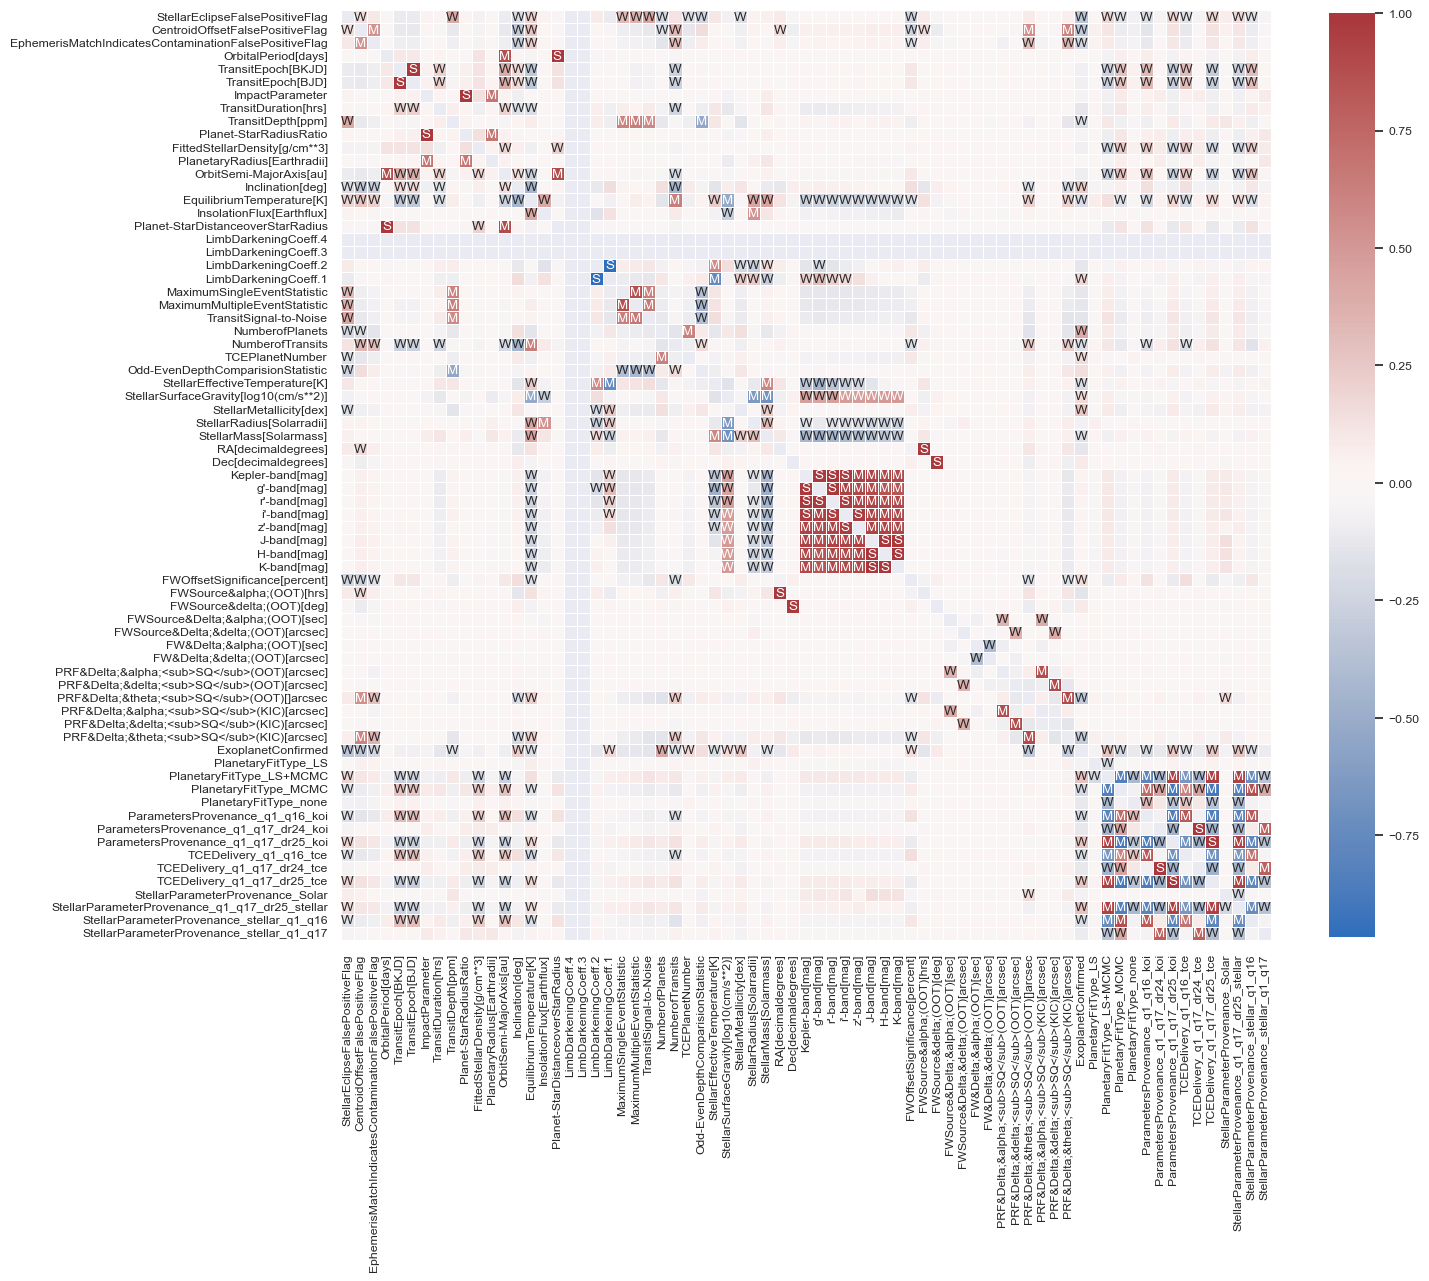

In [242]:
# Create labels for the correlation matrix
labels = np.where(np.abs(corr_matrix)>0.95, "S",
                  np.where(np.abs(corr_matrix)>0.5, "M",
                           np.where(np.abs(corr_matrix)>0.15, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, mask=np.eye(len(corr_matrix)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8})

## Class Balancing

In [246]:
X = df_work.drop('ExoplanetConfirmed', axis=1)
y = df_work['ExoplanetConfirmed']

In [249]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTETomek
print('Original dataset shape %s' % Counter(y))

smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0.0: 6557, 1.0: 2630})
Resampled dataset shape Counter({1.0: 6356, 0.0: 6356})


In [254]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, random_state=42)

In [256]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

### Feature Selection after SMOTE

In [258]:
feature_names = [f"feature {i}" for i in range(X_res.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [259]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

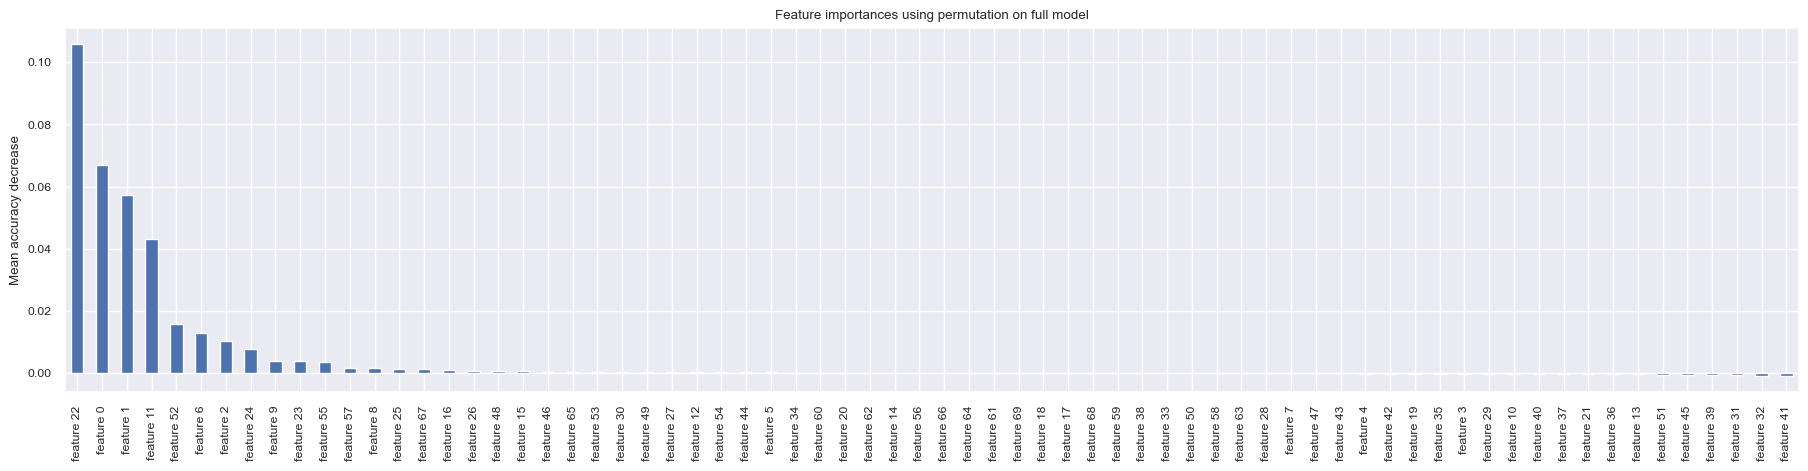

In [276]:
fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
fig.set_figwidth(20)
plt.show()

In [283]:
importance_df = pd.DataFrame({'Feature': X_res.columns, 'Importance': forest_importances})
importance_df = importance_df.sort_values('Importance', ascending=False)


In [287]:
importance_threshold = 0.001

In [294]:
important_features = importance_df[importance_df['Importance'] >= importance_threshold]['Feature']
X_res_filtered = X_res[important_features]


In [295]:
X_res_filtered

,MaximumMultipleEventStatistic,StellarEclipseFalsePositiveFlag,CentroidOffsetFalsePositiveFlag,PlanetaryRadius[Earthradii],PRF&Delta;&theta;<sub>SQ</sub>(OOT)[]arcsec,ImpactParameter,EphemerisMatchIndicatesContaminationFalsePositiveFlag,NumberofPlanets,Planet-StarRadiusRatio,TransitSignal-to-Noise,PRF&Delta;&theta;<sub>SQ</sub>(KIC)[arcsec],PlanetaryFitType_LS+MCMC,TransitDepth[ppm],NumberofTransits,StellarParameterProvenance_q1_q17_dr25_stellar,Planet-StarDistanceoverStarRadius
0,28.470820,0.0,0.0,2.260000,0.200000,0.146000,0.0,2.000000,0.022344,35.800000,0.320000,1.000000,615.800000,142.000000,1.000000,24.810000
1,20.109507,0.0,0.0,2.830000,0.390000,0.586000,0.0,2.000000,0.027954,25.800000,0.500000,1.000000,874.800000,25.000000,1.000000,77.900000
2,187.449100,0.0,0.0,14.600000,0.042000,0.969000,0.0,1.000000,0.154046,76.300000,0.027000,1.000000,10829.000000,56.000000,1.000000,53.500000
3,541.895100,1.0,0.0,33.460000,0.289000,1.276000,0.0,1.000000,0.387394,505.600000,0.276000,1.000000,8079.200000,621.000000,1.000000,3.278000
4,33.191900,0.0,0.0,2.750000,0.100000,0.701000,0.0,1.000000,0.024064,40.900000,0.070000,1.000000,603.300000,515.000000,1.000000,8.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12707,12.402650,0.0,0.0,1.498837,0.403808,0.429125,0.0,2.156978,0.017026,12.883431,0.436948,1.000000,345.672991,182.398227,1.000000,23.173889
12708,29.012747,0.0,0.0,1.725664,0.071888,0.458509,0.0,1.000000,0.018851,22.738474,0.135104,0.094397,440.893245,192.619344,0.094397,19.891146
12709,61.744636,0.0,0.0,3.309759,0.450918,0.100308,0.0,1.000000,0.032706,75.488852,0.048469,1.000000,1248.936561,218.521232,1.000000,14.434327
12710,14.522171,0.0,0.0,2.325795,0.041711,0.348178,0.0,1.828868,0.018072,17.889886,0.108289,1.000000,359.068619,66.449430,1.000000,34.213893


## Models

In [323]:
X_t = df_imputer_knn.drop('ExoplanetConfirmed', axis=1)
y_t = df_imputer_knn['ExoplanetConfirmed']

In [362]:
sc = StandardScaler()
X_res_scaled = sc.fit_transform(X_res_filtered)

In [365]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, random_state=42)

In [357]:
Counter(y_test)

Counter({1.0: 1589, 0.0: 1589})

In [366]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

In [367]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error, r2_score

In [369]:
# Grid search for Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg_params = {'C': [0.1, 1, 10]}
logreg_grid = GridSearchCV(logreg, logreg_params)
logreg_grid.fit(X_train, y_train)
logreg_best_params = logreg_grid.best_params_
logreg_best_model = logreg_grid.best_estimator_
logreg_predictions = logreg_best_model.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_predictions)
logreg_precision = precision_score(y_test, logreg_predictions)
logreg_recall = recall_score(y_test, logreg_predictions)
logreg_roc = roc_auc_score(y_test, logreg_predictions)

print([logreg_accuracy,logreg_precision,logreg_recall,logreg_roc])

[0.9191315292636879, 0.884083044982699, 0.9647577092511013, 0.9191315292636878]


In [308]:
# Grid search for Decision Trees
dt = DecisionTreeClassifier()
dt_params = {'max_depth': [None, 5, 10]}
dt_grid = GridSearchCV(dt, dt_params)
dt_grid.fit(X_train, y_train)
dt_best_params = dt_grid.best_params_
dt_best_model = dt_grid.best_estimator_
dt_predictions = dt_best_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_precision = precision_score(y_test, dt_predictions)
dt_recall = recall_score(y_test, dt_predictions)

In [309]:
# Grid search for Random Forests
rf = RandomForestClassifier(n_jobs=-1)
rf_params = {'n_estimators': [100, 200, 300]}
rf_grid = GridSearchCV(rf, rf_params)
rf_grid.fit(X_train, y_train)
rf_best_params = rf_grid.best_params_
rf_best_model = rf_grid.best_estimator_
rf_predictions = rf_best_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)

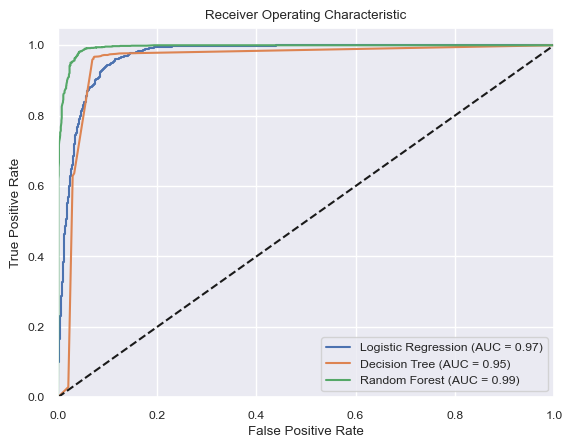

In [371]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(model_name, y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)

    plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(model_name, auc))

# Assuming you have trained multiple models and have their predictions and true labels available

# List of models
models = [
    ("Logistic Regression", logreg_best_model),
    ("Decision Tree", dt_best_model),
    ("Random Forest", rf_best_model)
]

# Iterate over the models and plot ROC curves
plt.figure()

for model_name, model in models:
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    plot_roc_curve(model_name, y_test, y_pred_prob)

# Plotting settings
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

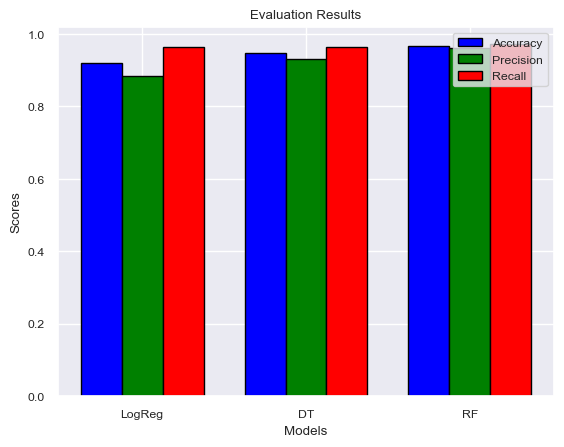

In [377]:
import matplotlib.pyplot as plt

# Evaluation results for each model

accuracy = [logreg_accuracy, dt_accuracy, rf_accuracy]
precision = [logreg_precision, dt_precision, rf_precision]
recall = [logreg_recall, dt_recall, rf_recall]

# Model names
models = ['LogReg', 'DT', 'RF']

# Set the width of the bars
bar_width = 0.25

# Set the positions of the bars on the x-axis
r1 = range(len(accuracy))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar plot
plt.bar(r1, accuracy, color='blue', width=bar_width, edgecolor='black', label='Accuracy')
plt.bar(r2, precision, color='green', width=bar_width, edgecolor='black', label='Precision')
plt.bar(r3, recall, color='red', width=bar_width, edgecolor='black', label='Recall')


# Add x-axis labels
plt.xlabel('Models')
plt.ylabel('Scores')

# Add y-axis label
plt.title('Evaluation Results')

# Add x-axis tick labels
plt.xticks([r + bar_width for r in range(len(accuracy))], models)

# Add a legend
plt.legend()

# Display the plot
plt.show()
